### Agent Defiend

In [121]:
from subprocess import Popen, PIPE
import os
from tempfile import mkdtemp
from werkzeug import secure_filename
import requests
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from gym import spaces, logger
import subprocess
from subprocess import Popen, PIPE
import numpy as np 
import time 
import pandas as pd 
class FooEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self):
        print('__init__')
        self.maxNode = 5 
        self.minNode =1 
        self.node = 2
        self.cpu_axis  = self.get_cpu_observation()
        self.mem_axis = self.get_mem_observation()
        self.disk_axis = self.get_disk_observation()
        self.net_axis  = self.get_net_observation()
        self.action_space = spaces.Discrete(9)
        high = np.array([
            self.get_cpu_observation(),
            self.get_mem_observation(),
            self.get_disk_observation(),
            self.get_net_observation()])
        low = np.array([
            np.zeros(5),
            np.zeros(5),
            np.zeros(5),
            np.zeros(5)])
        self.observation_space = spaces.Box(low, high, dtype=np.float32)
        self.seed()
        self.obs= 0
        self.obs = self.get_observation()
        self.viewer = None
        self.state = self.get_observation()
        self.attempt = 0 
        self.steps_beyond_done = None
        self.done = False
        self.adapte_cpu= False  
        self.adapte_mem= False 
        self.adapte_disk= False 
        self.adapte_net= False 
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def step(self, action):
        assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        state = self.get_observation()
        #past_stat = self.state
        #print(state)
        #Find the Utility Prefernces 
        # Select action 
        # get the reward value
       
        maxUtility = np.amax(self.obs[:,4])
        utilityType = np.argmax(self.obs[:,4])
        if utilityType== 0:
            self.adapte_cpu=True 
        elif utilityType== 1:
            self.adapte_mem = True
        elif utilityType== 2:
            self.adapte_disk = True
        elif utilityType== 3:
            self.adapte_net = True
        self.attempt += 1
        print('self.adapte_cpu: ', self.adapte_cpu, 'self.adapte_mem:', self.adapte_mem, 'self.adapte_disk:',self.adapte_disk,'self.adapte_net:', self.adapte_net )
        done=False
        reward=0
        #Here 
     
        if action == 0:
            print("Stay in State S0")
            self.obs = self.get_observation()
            reward= 1 - np.amax(self.obs[:,3]) 
        elif action == 1:
            print("Stay in State S0")
            self.obs = self.get_observation()
            reward= 1 - np.amax(self.obs[:,3])  
            if (self.attempt>300):
                done = True
                reward= 1
            else:
                done= False 
            info = "Stay in State S0"
            print("reward: ",reward, np.amax(self.obs[:,4]))
        elif action == 2: 
            print("Scale Service UP S2")
            try:
                response = requests.get(' http://192.168.99.100:5000/services/vscale/web/'+ str(self.attempt) + '/' + str(self.cpu_axis[0])+'/'+str(self.cpu_axis[3]))
                results = response.json()
                if results['result']=='Service converged':
                    done=True 
                    self.obs = self.get_observation()
                    reward= 1 
                else:
                    done= False
                    print(results)

                    self.obs = self.get_observation()
                    reward= 1 - np.amax(self.obs[:,3])  
                    print(reward)
            finally:
                info = "Scale Up Move to State S1"
                print("reward: ",reward, np.amax(self.obs[:,4]))
                pass

        elif action == 3: 
            print("Maintain Cluster State S4 and delete dangling docker containers")
          
            self.obs = self.get_observation()
            reward= 1 - np.amax(self.obs[:,3])
            print("reward: ",reward, np.amax(self.obs[:,4]))
            done= False
            if (self.attempt>300):
                done = True
                info = "delete dangling docker containers S4"
                cur_dir = os.getcwd()
                filepath = os.path.join(cur_dir, 'cleancontainers.sh')
                print (filepath)
                res= subprocess.call(filepath, shell=True)
                print (res)
                reward = 1
        elif action == 4: 

            current_state = self.obs

            if (self.node <= self.maxNode and self.node >= self.minNode ):
                print("Add Node S4")
                cur_dir = os.getcwd()
                filepath = os.path.join(cur_dir, 'addNode.sh')
                print (filepath)
                res= subprocess.call(filepath, shell=True)
                print (res)
                info = "Add Node S4"
                self.obs = self.get_observation()
                reward= 1  
                print("reward: ",reward, np.amax(self.obs[:,4]))
                done= True
                self.node +=1
                 
            elif self.node==5:
                    done=True 
                    reward=1
            else:
                print("Add Node to Cluster State S4: ", self.attempt)
                done= False
                self.obs = self.get_observation()
                reward= 1 - np.amax(self.obs[:,3])
                print("reward: ",reward, np.amax(self.obs[:,4]))
                
        elif action == 5: 

            self.obs = self.get_observation()
            if (self.node <= self.maxNode and self.node > self.minNode ):
                print("Delete Node S5")
                cur_dir = os.getcwd()
                filepath = os.path.join(cur_dir, 'deleteNode.sh')
                print (filepath)
                res= subprocess.call(filepath, shell=True)
                print (res)
                info = "Delete Node S5"
                reward= 1  
                print("reward: ",reward, np.amax(self.obs[:,4]))
                done= True
                 
                self.node -=1
               
            else:
                print("Maintain Cluster State S5: ", self.attempt, self.node, self.minNode, self.maxNode)
                done= False
                reward= 1 - np.amax(self.obs[:,3])
                print("reward: ",reward)
                if self.node==1:
                    done=True 
                    reward=1

        elif action==6:
            print("freedisk Space S6")
            cur_dir = os.getcwd()
            filepath = os.path.join(cur_dir, 'freedisk.sh')
            print (filepath)
            res= subprocess.call(filepath, shell=True)
            print (res)
            info = "freedisk Node S6"
            reward= 1  
            print("reward: ",reward, np.amax(self.obs[:,4]))
            done= True
             

        elif action == 7:
            print("rollback and enforce new cluster")
            #Reward = max of utility fitness
            try:
                cur_dir = os.getcwd()
                #filepath = os.path.join(cur_dir, 'newcluster.sh')
                #print (filepath)
                #res= subprocess.call(filepath, shell=True)
                #print (res)
                info = "rollback and enforce new  cluster S7"
                time.sleep(300)
                reward= 1 
                print("reward: ",reward, np.amax(self.obs[:,4]))
                done= True
                 
                self.obs = self.get_observation()
                reward= 1  
                print(reward)
                info = "rollback and enforce new cluster"
            finally:
                pass
              

        elif action==8:
            if (self.attempt>10 and self.attempt <13 and self.node < self.maxNode and self.node >= self.minNode ):
                
                cur_dir = os.getcwd()
                filepath = os.path.join(cur_dir, 'manager.sh')
                print (filepath)
                res= subprocess.call(filepath, shell=True)
                print (res)
                info = "Add Manager node S8"
                self.node += 1
                reward= 1 
                print("reward: ",reward, np.amax(self.obs[:,4]), "Node: ", self.node)
                done= True
                 
            else:
                print("Maintain Cluster State S8", self.attempt)
                reward= 1 - np.amax(self.obs[:,3])
                done= False
                print("reward: ",reward, np.amax(self.obs[:,4]))
        else: 
            print ("action not defined")
            self.obs = self.get_observation()
            done= False
            reward= -1
            info = "action not defined"
        
        if done: 
            reward = 1.0
        elif self.steps_beyond_done is None:
            #Adaptation Failed 
            reward = 0.0 
            self.steps_beyond_done = 0
        else: 
            if self.steps_beyond_done == 1:
                logger.warn("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
                self.steps_beyond_done += 1
                reward = 0.0
         
        return self.obs, reward, done, {}
    def reset(self):
        self.state = self.get_observation()
        self.steps_beyond_done = None
        self.adapte_cpu= False  
        self.adapte_mem= False 
        self.adapte_disk= False 
        self.adapte_net= False 
        self.maxNode = 5 
        self.minNode =1 
        return np.array(self.state)
    def render(self, mode='human', close=False):
        logger.warn("View is not allowed in this environment")
        return 0 
    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None
    def get_observation(self):
        try:
            self.disk_axis = self.get_disk_observation() 
            self.mem_axis = self.get_mem_observation()
            self.cpu_axis = self.get_cpu_observation()
            self.net_axis = self.get_net_observation()
            obs =np.vstack((self.cpu_axis,self.mem_axis, self.disk_axis, self.net_axis) )
            return obs 
        finally: 
            pass 
        
    def get_cpu_observation(self):
        try: 
            response = requests.get('http://192.168.99.100:8888/cpu', timeout=5)
            results = response.json()
            if len(results) > 0:
                    cpu = results['cpu']
                    prediction = results['prediction']
                    anomalyScore = results['anomalyScore']
                    anomalyLikelihood = results['anomalyLikelihood']
                    utility_cpu = results['utility_cpu']
                    cpu_axis=[cpu, prediction, anomalyScore, anomalyLikelihood, utility_cpu]
            return np.array(cpu_axis)
        finally: 
            pass
    def get_mem_observation(self):
        try:
            response = requests.get('http://192.168.99.100:8888/mem', timeout=5)
            results = response.json()
            if len(results) > 0:
                mem = results['mem']
                prediction = results['prediction']
                anomalyScore = results['anomalyScore']
                anomalyLikelihood = results['anomalyLikelihood']
                utility_mem = results['utility_mem']
                mem_axis=[mem, prediction, anomalyScore, anomalyLikelihood, utility_mem]
                return np.array(mem_axis)
        finally: 
            pass
    def get_net_observation(self):
        try:
            response = requests.get('http://192.168.99.100:8888/net', timeout=5)
            results = response.json()
            if len(results) > 0:
                net = results['net']
                prediction = results['prediction']
                anomalyScore = results['anomalyScore']
                anomalyLikelihood = results['anomalyLikelihood']
                utility_net = results['utility_net']
                net_axis=[net, prediction, anomalyScore, anomalyLikelihood, utility_net]
            return np.array(net_axis)
        finally:
            pass 
    def get_disk_observation(self):
        try:
            response = requests.get('http://192.168.99.100:8888/disk', timeout=5)
            if response is not None:
                results = response.json()
                if len(results) > 0:
                    disk = results['disk']
                    prediction = results['prediction']
                    anomalyScore = results['anomalyScore']
                    anomalyLikelihood = results['anomalyLikelihood']
                    utility_disk = results['utility_disk']
            disk_axis=[disk, prediction, anomalyScore, anomalyLikelihood, utility_disk]
            return np.array(disk_axis)
        finally: 
            pass

    def get_current_state(self):
        current_state = self.state
         
        return current_state

### call the agent 

In [122]:
import gym
import gym_foo

env = FooEnv()

__init__


In [123]:
env.reset()

array([[ 7.26666667,  7.26666667,  1.        ,  0.5       ,  3.63333333],
       [30.71002509, 30.71002509,  1.        ,  0.5       , 15.35501254],
       [90.        , 90.        ,  1.        ,  0.5       , 45.        ],
       [71.2       , 71.2       ,  1.        ,  0.5       , 35.6       ]])

##  call Keras API and Keras rl

In [124]:
from __future__ import division, print_function, unicode_literals
import csv
import shutil
import os
import time
import requests
import subprocess
from subprocess import call
import numpy as np
import tensorflow as tf
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
import pandas as pd 


In [125]:
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory 

In [126]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [127]:
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# # # MDP 


## Deep Q-Learning


In [128]:
env.observation_space.shape

(4, 5)

In [129]:
nb_actions= env.action_space.n
nb_actions

9

In [130]:
env.node

2

In [131]:
# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))

In [132]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)                336       
_________________________________________________________________
activation_17 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_18 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_19 (Activation)   (None, 16)                0         
__________

In [133]:
memory = SequentialMemory(limit=1000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [134]:
%%time
ENV_NAME="micro_with_swarmed"
weights_filename = 'mydqn_{}_weights.h5f'.format(ENV_NAME)
checkpoint_weights_filename = 'dqn_' + ENV_NAME + '_weights_{step}.h5f'
log_filename = 'mydqn_{}_log.json'.format(ENV_NAME)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=2000)]
callbacks += [FileLogger(log_filename, interval=2000)]
dqn.fit(env, callbacks=callbacks, nb_steps=2000, log_interval=2000)

Training for 2000 steps ...
Interval 1 (0 steps performed)
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: True self.adapte_net: False
Add Node S4
/Users/baz/ieee-demo/addNode.sh
0
reward:  0.5 1574.5333333333333
   1/2000 [..............................] - ETA: 45:14:57 - reward: 1.0000self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Add Node S4
/Users/baz/ieee-demo/addNode.sh
0
reward:  0.5 38.0
   2/2000 [..............................] - ETA: 48:19:59 - reward: 1.0000self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: True self.adapte_net: False
Add Node S4
/Users/baz/ieee-demo/addNode.sh
0
reward:  0.5 42.23630501799058
   3/2000 [..............................] - ETA: 50:19:30 - reward: 1.0000self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Add Node S4
/Users/baz/ieee-demo/addNode.sh
0
reward:  0.5 75.23668760066734
   4/2000 [..............................] - ETA

/anaconda3/lib/python3.6/site-packages/keras_rl-0.4.2-py3.6.egg/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


  12/2000 [..............................] - ETA: 17:33:02 - reward: 0.6250self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  9
reward:  0.5 4492.8962113127
  13/2000 [..............................] - ETA: 16:14:22 - reward: 0.6154self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  10
reward:  0.5 3170.1574172892206
  14/2000 [..............................] - ETA: 15:07:11 - reward: 0.6071self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 11
reward:  0.5 3170.1574172892206
  15/2000 [..............................] - ETA: 14:07:24 - reward: 0.6000self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 12
reward:  0.5 3170.1574172892206
  16/2000 [..............................] - ETA: 13:15:20 - reward: 0.5938self.adapte_c

  48/2000 [..............................] - ETA: 4:42:54 - reward: 0.5312self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  45
reward:  0.5 17.279135681737145
  49/2000 [..............................] - ETA: 4:37:39 - reward: 0.5306self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  46
reward:  0.5 17.279135681737145
  50/2000 [..............................] - ETA: 4:32:40 - reward: 0.5300self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  47
reward:  0.5 17.279135681737145
  51/2000 [..............................] - ETA: 4:27:52 - reward: 0.5294self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  48
reward:  0.5 11636.566666666666
  52/2000 [..............................] - ETA: 4:23:16 - reward: 0.5288self.adapt

  84/2000 [>.............................] - ETA: 2:52:31 - reward: 0.5179self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 81
reward:  0.5 1806.2183417755264
  85/2000 [>.............................] - ETA: 2:50:34 - reward: 0.5176self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 82
reward:  0.5 1806.2183417755264
  86/2000 [>.............................] - ETA: 2:48:41 - reward: 0.5174self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 83
reward:  0.5 1806.2183417755264
  87/2000 [>.............................] - ETA: 2:46:49 - reward: 0.5172self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 84
reward:  0.5 1806.2183417755264
  88/2000 [>.............................] - ETA: 2:44:59 - reward: 0.5170self.adapte_cpu:  True

 120/2000 [>.............................] - ETA: 2:02:37 - reward: 0.5125self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 117
reward:  0.5 1806.2183417755264
 121/2000 [>.............................] - ETA: 2:01:39 - reward: 0.5124self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 118
reward:  0.5 1806.2183417755264
 122/2000 [>.............................] - ETA: 2:00:42 - reward: 0.5123self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 119
reward:  0.5 1806.2183417755264
 123/2000 [>.............................] - ETA: 1:59:46 - reward: 0.5122self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 120
reward:  0.5 1806.2183417755264
 124/2000 [>.............................] - ETA: 1:58:51 - reward: 0.5121self.adapte_cpu:  

 156/2000 [=>............................] - ETA: 1:38:00 - reward: 0.5096self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 153
reward:  0.5 1806.2183417755264
 157/2000 [=>............................] - ETA: 1:37:30 - reward: 0.5096self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 154
reward:  0.5 1806.2183417755264
 158/2000 [=>............................] - ETA: 1:37:00 - reward: 0.5095self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 155
reward:  0.5 1806.2183417755264
 159/2000 [=>............................] - ETA: 1:36:29 - reward: 0.5094self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 156
reward:  0.5 1806.2183417755264
 160/2000 [=>............................] - ETA: 1:35:57 - reward: 0.5094self.adapte_cpu:  

 192/2000 [=>............................] - ETA: 1:21:30 - reward: 0.5078self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 189
reward:  0.5 1806.2183417755264
 193/2000 [=>............................] - ETA: 1:21:07 - reward: 0.5078self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 190
reward:  0.5 1806.2183417755264
 194/2000 [=>............................] - ETA: 1:20:45 - reward: 0.5077self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 191
reward:  0.5 1806.2183417755264
 195/2000 [=>............................] - ETA: 1:20:22 - reward: 0.5077self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 192
reward:  0.5 1806.2183417755264
 196/2000 [=>............................] - ETA: 1:20:00 - reward: 0.5077self.adapte_cpu:  

 228/2000 [==>...........................] - ETA: 1:09:58 - reward: 0.5066self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 225
reward:  0.5 1806.2183417755264
 229/2000 [==>...........................] - ETA: 1:09:43 - reward: 0.5066self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 226
reward:  0.5 1806.2183417755264
 230/2000 [==>...........................] - ETA: 1:09:27 - reward: 0.5065self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 227
reward:  0.5 1806.2183417755264
 231/2000 [==>...........................] - ETA: 1:09:12 - reward: 0.5065self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 228
reward:  0.5 1806.2183417755264
 232/2000 [==>...........................] - ETA: 1:08:57 - reward: 0.5065self.adapte_cpu:  

 264/2000 [==>...........................] - ETA: 1:01:39 - reward: 0.5057self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 261
reward:  0.5 1806.2183417755264
 265/2000 [==>...........................] - ETA: 1:01:29 - reward: 0.5057self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 262
reward:  0.5 1806.2183417755264
 266/2000 [==>...........................] - ETA: 1:01:17 - reward: 0.5056self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 263
reward:  0.5 1806.2183417755264
 267/2000 [===>..........................] - ETA: 1:01:06 - reward: 0.5056self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 264
reward:  0.5 1806.2183417755264
 268/2000 [===>..........................] - ETA: 1:00:56 - reward: 0.5056self.adapte_cpu:  

 300/2000 [===>..........................] - ETA: 55:50 - reward: 0.5050self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 297
reward:  0.5 1806.2183417755264
 301/2000 [===>..........................] - ETA: 55:41 - reward: 0.5050self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 298
reward:  0.5 1806.2183417755264
 302/2000 [===>..........................] - ETA: 55:31 - reward: 0.5050self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 299
reward:  0.5 1806.2183417755264
 303/2000 [===>..........................] - ETA: 55:22 - reward: 0.5050self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 300
reward:  0.5 1806.2183417755264
 304/2000 [===>..........................] - ETA: 55:12 - reward: 0.5049self.adapte_cpu:  True self.

 337/2000 [====>.........................] - ETA: 50:19 - reward: 0.5045self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 334
reward:  0.5 1806.2183417755264
 338/2000 [====>.........................] - ETA: 50:11 - reward: 0.5044self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 335
reward:  0.5 1806.2183417755264
 339/2000 [====>.........................] - ETA: 50:03 - reward: 0.5044self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 336
reward:  0.5 1806.2183417755264
 340/2000 [====>.........................] - ETA: 49:55 - reward: 0.5044self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 337
reward:  0.5 1806.2183417755264
 341/2000 [====>.........................] - ETA: 49:47 - reward: 0.5044self.adapte_cpu:  True self.

 374/2000 [====>.........................] - ETA: 45:31 - reward: 0.5040self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 371
reward:  0.5 1806.2183417755264
 375/2000 [====>.........................] - ETA: 45:24 - reward: 0.5040self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 372
reward:  0.5 1806.2183417755264
 376/2000 [====>.........................] - ETA: 45:17 - reward: 0.5040self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 373
reward:  0.5 1806.2183417755264
 377/2000 [====>.........................] - ETA: 45:10 - reward: 0.5040self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 374
reward:  0.5 1806.2183417755264
 378/2000 [====>.........................] - ETA: 45:02 - reward: 0.5040self.adapte_cpu:  True self.

reward:  0.5 84.5728763496486
 411/2000 [=====>........................] - ETA: 42:27 - reward: 0.5036self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  408
reward:  0.5 17.307059315793886
 412/2000 [=====>........................] - ETA: 42:22 - reward: 0.5036self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  409
reward:  0.5 15737.3
 413/2000 [=====>........................] - ETA: 42:18 - reward: 0.5036self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  410 6 1 5
reward:  0.5
 414/2000 [=====>........................] - ETA: 42:14 - reward: 0.5036self.adapte_cpu:  True self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  411
reward:  0.5 8093.7832800851975
 415/2000 [=====>........................] - ETA: 42:16 - reward: 0.5036self.adapte_cp

 447/2000 [=====>........................] - ETA: 40:58 - reward: 0.5034self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 444
reward:  0.5 6398.115351199625
 448/2000 [=====>........................] - ETA: 40:53 - reward: 0.5033self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 445
reward:  0.5 6398.115351199625
 449/2000 [=====>........................] - ETA: 40:48 - reward: 0.5033self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  446
reward:  0.5 39.932448947847924
 450/2000 [=====>........................] - ETA: 40:45 - reward: 0.5033self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  447
reward:  0.5 17.336737379947273
 451/2000 [=====>........................] - ETA: 40:41 - reward: 0.5033self.adapte_cpu:  Fals

 483/2000 [======>.......................] - ETA: 43:47 - reward: 0.5031self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 480
reward:  0.5 1960.85421108742
 484/2000 [======>.......................] - ETA: 43:49 - reward: 0.5031self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 481
reward:  0.5 1960.85421108742
 485/2000 [======>.......................] - ETA: 43:52 - reward: 0.5031self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 482
reward:  0.5 1960.85421108742
 486/2000 [======>.......................] - ETA: 43:55 - reward: 0.5031self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 483
reward:  0.5 1960.85421108742
 487/2000 [======>.......................] - ETA: 43:58 - reward: 0.5031self.adapte_cpu:  False self.ada

 520/2000 [======>.......................] - ETA: 44:44 - reward: 0.5029self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 517
reward:  0.5 1960.85421108742
 521/2000 [======>.......................] - ETA: 44:43 - reward: 0.5029self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 518
reward:  0.5 1960.85421108742
 522/2000 [======>.......................] - ETA: 44:43 - reward: 0.5029self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 519
reward:  0.5 1960.85421108742
 523/2000 [======>.......................] - ETA: 44:44 - reward: 0.5029self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 520
reward:  0.5 1960.85421108742
 524/2000 [======>.......................] - ETA: 44:44 - reward: 0.5029self.adapte_cpu:  False self.ada

 557/2000 [=======>......................] - ETA: 44:31 - reward: 0.5027self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 554
reward:  0.5 1960.85421108742
 558/2000 [=======>......................] - ETA: 44:29 - reward: 0.5027self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 555
reward:  0.5 1960.85421108742
 559/2000 [=======>......................] - ETA: 44:28 - reward: 0.5027self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 556
reward:  0.5 1960.85421108742
 560/2000 [=======>......................] - ETA: 44:28 - reward: 0.5027self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 557
reward:  0.5 1960.85421108742
 561/2000 [=======>......................] - ETA: 44:28 - reward: 0.5027self.adapte_cpu:  False self.ada

 594/2000 [=======>......................] - ETA: 44:25 - reward: 0.5025self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 591
reward:  0.5 1960.85421108742
 595/2000 [=======>......................] - ETA: 44:24 - reward: 0.5025self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 592
reward:  0.5 1960.85421108742
 596/2000 [=======>......................] - ETA: 44:24 - reward: 0.5025self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 593
reward:  0.5 1960.85421108742
 597/2000 [=======>......................] - ETA: 44:24 - reward: 0.5025self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 594
reward:  0.5 1960.85421108742
 598/2000 [=======>......................] - ETA: 44:24 - reward: 0.5025self.adapte_cpu:  False self.ada

 631/2000 [========>.....................] - ETA: 44:15 - reward: 0.5024self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 628
reward:  0.5 1960.85421108742
 632/2000 [========>.....................] - ETA: 44:15 - reward: 0.5024self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 629
reward:  0.5 1960.85421108742
 633/2000 [========>.....................] - ETA: 44:15 - reward: 0.5024self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 630
reward:  0.5 1960.85421108742
 634/2000 [========>.....................] - ETA: 44:16 - reward: 0.5024self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 631
reward:  0.5 1960.85421108742
 635/2000 [========>.....................] - ETA: 44:16 - reward: 0.5024self.adapte_cpu:  False self.ada

 668/2000 [=========>....................] - ETA: 43:06 - reward: 0.5022self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 665
reward:  0.5 1960.85421108742
 669/2000 [=========>....................] - ETA: 43:02 - reward: 0.5022self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 666
reward:  0.5 1960.85421108742
 670/2000 [=========>....................] - ETA: 42:57 - reward: 0.5022self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  667
reward:  0.5 17.33022808109053
 671/2000 [=========>....................] - ETA: 42:53 - reward: 0.5022self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  668
reward:  0.5 68.72786762296843
 672/2000 [=========>....................] - ETA: 42:49 - reward: 0.5022self.adapte_cpu:  False se

 704/2000 [=========>....................] - ETA: 40:22 - reward: 0.5021self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 701
reward:  0.5 2282.6289828022927
 705/2000 [=========>....................] - ETA: 40:18 - reward: 0.5021self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 702
reward:  0.5 2282.6289828022927
 706/2000 [=========>....................] - ETA: 40:13 - reward: 0.5021self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 703
reward:  0.5 2282.6289828022927
 707/2000 [=========>....................] - ETA: 40:09 - reward: 0.5021self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 704
reward:  0.5 2282.6289828022927
 708/2000 [=========>....................] - ETA: 40:04 - reward: 0.5021self.adapte_cpu:  False 

 740/2000 [==========>...................] - ETA: 37:55 - reward: 0.5020self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  737
reward:  0.5 139.77844406815154
 741/2000 [==========>...................] - ETA: 37:52 - reward: 0.5020self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  738
reward:  0.5 140.28386041359772
 742/2000 [==========>...................] - ETA: 37:49 - reward: 0.5020self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  739
reward:  0.5 17.32109415161201
 743/2000 [==========>...................] - ETA: 37:45 - reward: 0.5020self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  740
reward:  0.5 140.28386041359772
 744/2000 [==========>...................] - ETA: 37:42 - reward: 0.5020self.adapte_cpu: 

reward:  0.5 17.3362463972228
 777/2000 [==========>...................] - ETA: 35:59 - reward: 0.5019self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  774
reward:  0.5 17.3362463972228
 778/2000 [==========>...................] - ETA: 35:56 - reward: 0.5019self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  775
reward:  0.5 7668.366666666667
 779/2000 [==========>...................] - ETA: 35:53 - reward: 0.5019self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  776 6 1 5
reward:  0.5
 780/2000 [==========>...................] - ETA: 35:50 - reward: 0.5019self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  777
reward:  0.5 12606.5
 781/2000 [==========>...................] - ETA: 35:46 - reward: 0.5019self.adapte_c

 813/2000 [===========>..................] - ETA: 34:24 - reward: 0.5018self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  810
reward:  0.5 6697.3
 814/2000 [===========>..................] - ETA: 34:21 - reward: 0.5018self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  811
reward:  0.5 138.97243727244106
 815/2000 [===========>..................] - ETA: 34:18 - reward: 0.5018self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  812
reward:  0.5 17.37847931601869
 816/2000 [===========>..................] - ETA: 34:15 - reward: 0.5018self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  813
reward:  0.5 7254.133333333333
 817/2000 [===========>..................] - ETA: 34:12 - reward: 0.5018self.adapte_cpu:  False self.a

reward:  0.5 14071.233333333334
 850/2000 [===========>..................] - ETA: 32:45 - reward: 0.5018self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  847 6 1 5
reward:  0.5
 851/2000 [===========>..................] - ETA: 32:43 - reward: 0.5018self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  848
reward:  0.5 17.37897129197262
 852/2000 [===========>..................] - ETA: 32:42 - reward: 0.5018self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  849
reward:  0.5 17.390552723253272
 853/2000 [===========>..................] - ETA: 32:40 - reward: 0.5018self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  850
reward:  0.5 5428.566666666667
 854/2000 [===========>..................] - ETA: 32:39 - reward: 0.501

 886/2000 [============>.................] - ETA: 31:43 - reward: 0.5017self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  883
reward:  0.5 17.44644587653928
 887/2000 [============>.................] - ETA: 31:42 - reward: 0.5017self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  884
reward:  0.5 17.44582074246447
 888/2000 [============>.................] - ETA: 31:40 - reward: 0.5017self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  885
reward:  0.5 17.403160225784532
 889/2000 [============>.................] - ETA: 31:39 - reward: 0.5017self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  886
reward:  0.5 86.66886248807268
 890/2000 [============>.................] - ETA: 31:37 - reward: 0.5017self.adapte_cpu:  F

 922/2000 [============>.................] - ETA: 30:44 - reward: 0.5016self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  919 6 1 5
reward:  0.5
 923/2000 [============>.................] - ETA: 30:43 - reward: 0.5016self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  920
reward:  0.5 17.41808196457002
 924/2000 [============>.................] - ETA: 30:41 - reward: 0.5016self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  921
reward:  0.5 84.29964858034467
 925/2000 [============>.................] - ETA: 30:40 - reward: 0.5016self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  922
reward:  0.5 17.418937411198705
 926/2000 [============>.................] - ETA: 30:38 - reward: 0.5016self.adapte_cpu:  False self.ad

reward:  0.5 17.47234402400683
 959/2000 [=============>................] - ETA: 29:47 - reward: 0.5016self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  956
reward:  0.5 141.68083228900232
 960/2000 [=============>................] - ETA: 29:46 - reward: 0.5016self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  957
reward:  0.5 5322.866666666667
 961/2000 [=============>................] - ETA: 29:44 - reward: 0.5016self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  958 6 1 5
reward:  0.5
 962/2000 [=============>................] - ETA: 29:42 - reward: 0.5016self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  959
reward:  0.5 122.44536431482481
 963/2000 [=============>................] - ETA: 29:41 - reward: 0.501

 995/2000 [=============>................] - ETA: 28:45 - reward: 0.5015self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  992
reward:  0.5 134.70688530927384
 996/2000 [=============>................] - ETA: 28:43 - reward: 0.5015self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  993
reward:  0.5 17.441631186316336
 997/2000 [=============>................] - ETA: 28:41 - reward: 0.5015self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  994
reward:  0.5 140.99172119239114
 998/2000 [=============>................] - ETA: 28:40 - reward: 0.5015self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  995
reward:  0.5 93.30845107971207
 999/2000 [=============>................] - ETA: 28:38 - reward: 0.5015self.adapte_cpu: 

reward:  0.5 137.52209852817518
1032/2000 [==============>...............] - ETA: 27:47 - reward: 0.5015self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1029
reward:  0.5 17.413097364418157
1033/2000 [==============>...............] - ETA: 27:46 - reward: 0.5015self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1030
reward:  0.5 17.413097364418157
1034/2000 [==============>...............] - ETA: 27:45 - reward: 0.5015self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1031
reward:  0.5 3735.090291197441
1035/2000 [==============>...............] - ETA: 27:43 - reward: 0.5014self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1032
reward:  0.5 3735.090291197441
1036/2000 [==============>...............] - ETA: 27:41 

1068/2000 [===============>..............] - ETA: 26:46 - reward: 0.5014self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1065
reward:  0.5 142.56006457125218
1069/2000 [===============>..............] - ETA: 26:45 - reward: 0.5014self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1066
reward:  0.5 17.410254180389167
1070/2000 [===============>..............] - ETA: 26:43 - reward: 0.5014self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1067
reward:  0.5 98.45287964953013
1071/2000 [===============>..............] - ETA: 26:41 - reward: 0.5014self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1068
reward:  0.5 17.39864202159705
1072/2000 [===============>..............] - ETA: 26:40 - reward: 0.5014self.adapte_cp

1104/2000 [===============>..............] - ETA: 25:47 - reward: 0.5014self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1101 6 1 5
reward:  0.5
1105/2000 [===============>..............] - ETA: 25:45 - reward: 0.5014self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1102
reward:  0.5 17.428178896291413
1106/2000 [===============>..............] - ETA: 25:43 - reward: 0.5014self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1103
reward:  0.5 84.34929931286041
1107/2000 [===============>..............] - ETA: 25:42 - reward: 0.5014self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1104
reward:  0.5 138.9178462216432
1108/2000 [===============>..............] - ETA: 25:40 - reward: 0.5014self.adapte_cpu:  False sel

1140/2000 [================>.............] - ETA: 24:49 - reward: 0.5013self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1137
reward:  0.5 82.20342715751534
1141/2000 [================>.............] - ETA: 24:47 - reward: 0.5013self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1138
reward:  0.5 93.65793551199937
1142/2000 [================>.............] - ETA: 24:45 - reward: 0.5013self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1139
reward:  0.5 46.66355576294914
1143/2000 [================>.............] - ETA: 24:44 - reward: 0.5013self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1140
reward:  0.5 5302.105543710021
1144/2000 [================>.............] - ETA: 24:42 - reward: 0.5013self.adapte_cpu:

1176/2000 [================>.............] - ETA: 23:50 - reward: 0.5013self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1173
reward:  0.5 84.32716539736384
1177/2000 [================>.............] - ETA: 23:48 - reward: 0.5013self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1174
reward:  0.5 17.435373751785697
1178/2000 [================>.............] - ETA: 23:47 - reward: 0.5013self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1175
reward:  0.5 6709.366666666667
1179/2000 [================>.............] - ETA: 23:45 - reward: 0.5013self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1176 6 1 5
reward:  0.5
1180/2000 [================>.............] - ETA: 23:44 - reward: 0.5013self.adapte_cpu:  False sel

1212/2000 [=================>............] - ETA: 22:52 - reward: 0.5012self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1209
reward:  0.5 91.87357430904392
1213/2000 [=================>............] - ETA: 22:50 - reward: 0.5012self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1210
reward:  0.5 17.444858382849247
1214/2000 [=================>............] - ETA: 22:49 - reward: 0.5012self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1211
reward:  0.5 6003.733333333334
1215/2000 [=================>............] - ETA: 22:47 - reward: 0.5012self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1212
reward:  0.5 6003.733333333334
1216/2000 [=================>............] - ETA: 22:45 - reward: 0.5012self.adapte_cpu: 

1248/2000 [=================>............] - ETA: 21:54 - reward: 0.5012self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1245
reward:  0.5 55.85959488272921
1249/2000 [=================>............] - ETA: 21:52 - reward: 0.5012self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1246
reward:  0.5 17.44712499072697
1250/2000 [=================>............] - ETA: 21:51 - reward: 0.5012self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1247
reward:  0.5 89.26832573710377
1251/2000 [=================>............] - ETA: 21:49 - reward: 0.5012self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1248
reward:  0.5 5202.292110874201
1252/2000 [=================>............] - ETA: 21:47 - reward: 0.5012self.adapte_cpu:

1284/2000 [==================>...........] - ETA: 20:54 - reward: 0.5012self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1281 6 1 5
reward:  0.5
1285/2000 [==================>...........] - ETA: 20:52 - reward: 0.5012self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1282
reward:  0.5 88.72148136080475
1286/2000 [==================>...........] - ETA: 20:51 - reward: 0.5012self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1283
reward:  0.5 66.53776497636329
1287/2000 [==================>...........] - ETA: 20:49 - reward: 0.5012self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1284
reward:  0.5 66.53776497636329
1288/2000 [==================>...........] - ETA: 20:48 - reward: 0.5012self.adapte_cpu:  False self

1320/2000 [==================>...........] - ETA: 19:48 - reward: 0.5011self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1317
reward:  0.5 17.48472945824188
1321/2000 [==================>...........] - ETA: 19:46 - reward: 0.5011self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1318
reward:  0.5 66.5395341450144
1322/2000 [==================>...........] - ETA: 19:44 - reward: 0.5011self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1319
reward:  0.5 4678.795357524012
1323/2000 [==================>...........] - ETA: 19:42 - reward: 0.5011self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1320
reward:  0.5 4678.795357524012
1324/2000 [==================>...........] - ETA: 19:39 - reward: 0.5011self.adapte_cpu:  F

1356/2000 [===================>..........] - ETA: 18:31 - reward: 0.5011self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1353
reward:  0.5 17.494639444066408
1357/2000 [===================>..........] - ETA: 18:28 - reward: 0.5011self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1354
reward:  0.5 46.64179104477613
1358/2000 [===================>..........] - ETA: 18:26 - reward: 0.5011self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1355
reward:  0.5 17.494573640479587
1359/2000 [===================>..........] - ETA: 18:24 - reward: 0.5011self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1356
reward:  0.5 7778.984541577825
1360/2000 [===================>..........] - ETA: 18:23 - reward: 0.5011self.adapte_cp

1392/2000 [===================>..........] - ETA: 17:36 - reward: 0.5011self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1389
reward:  0.5 88.74341057136591
1393/2000 [===================>..........] - ETA: 17:34 - reward: 0.5011self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1390
reward:  0.5 138.45040849005557
1394/2000 [===================>..........] - ETA: 17:32 - reward: 0.5011self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1391
reward:  0.5 17.50229729386666
1395/2000 [===================>..........] - ETA: 17:31 - reward: 0.5011self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1392
reward:  0.5 116.95454499005521
1396/2000 [===================>..........] - ETA: 17:29 - reward: 0.5011self.adapte_cp

1428/2000 [====================>.........] - ETA: 16:35 - reward: 0.5011self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1425
reward:  0.5 17.675952507264412
1429/2000 [====================>.........] - ETA: 16:34 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1426
reward:  0.5 85.08903275637499
1430/2000 [====================>.........] - ETA: 16:32 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1427
reward:  0.5 17.675952507264412
1431/2000 [====================>.........] - ETA: 16:30 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1428
reward:  0.5 5236.440565031983
1432/2000 [====================>.........] - ETA: 16:29 - reward: 0.5010self.adapte_cp

1464/2000 [====================>.........] - ETA: 15:33 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1461
reward:  0.5 17.512501177805312
1465/2000 [====================>.........] - ETA: 15:31 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1462
reward:  0.5 84.33277756145745
1466/2000 [====================>.........] - ETA: 15:29 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1463
reward:  0.5 82.4645281717965
1467/2000 [=====================>........] - ETA: 15:28 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1464
reward:  0.5 84.33277756145745
1468/2000 [=====================>........] - ETA: 15:26 - reward: 0.5010self.adapte_cpu:

1500/2000 [=====================>........] - ETA: 14:28 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1497
reward:  0.5 17.526562065131202
1501/2000 [=====================>........] - ETA: 14:26 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1498
reward:  0.5 17.526562065131202
1502/2000 [=====================>........] - ETA: 14:24 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1499
reward:  0.5 17.526562065131202
1503/2000 [=====================>........] - ETA: 14:22 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1500
reward:  0.5 17.527220100999422
1504/2000 [=====================>........] - ETA: 14:21 - reward: 0.5010self.adapte_cpu:  

1536/2000 [======================>.......] - ETA: 13:23 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1533
reward:  0.5 17.573205507070092
1537/2000 [======================>.......] - ETA: 13:21 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1534
reward:  0.5 17.573205507070092
1538/2000 [======================>.......] - ETA: 13:20 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1535
reward:  0.5 17.573205507070092
1539/2000 [======================>.......] - ETA: 13:18 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1536
reward:  0.5 42.52536187294382
1540/2000 [======================>.......] - ETA: 13:16 - reward: 0.5010self.adapte_cpu:  F

1572/2000 [======================>.......] - ETA: 12:21 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1569
reward:  0.5 17.544488073382
1573/2000 [======================>.......] - ETA: 12:19 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1570
reward:  0.5 138.80781991454506
1574/2000 [======================>.......] - ETA: 12:18 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1571
reward:  0.5 100.94295673699425
1575/2000 [======================>.......] - ETA: 12:16 - reward: 0.5010self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1572
reward:  0.5 3652.0261263663024
1576/2000 [======================>.......] - ETA: 12:14 - reward: 0.5010self.adapte_cpu

1608/2000 [=======================>......] - ETA: 11:18 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1605
reward:  0.5 55.795579251360664
1609/2000 [=======================>......] - ETA: 11:16 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1606
reward:  0.5 55.795579251360664
1610/2000 [=======================>......] - ETA: 11:14 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1607
reward:  0.5 46.61779406864378
1611/2000 [=======================>......] - ETA: 11:12 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1608
reward:  0.5 17.553664379512277
1612/2000 [=======================>......] - ETA: 11:11 - reward: 0.5009self.adapte_cpu: 

reward:  0.5 6273.133333333332
1645/2000 [=======================>......] - ETA: 10:13 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1642
reward:  0.5 6273.133333333332
1646/2000 [=======================>......] - ETA: 10:11 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1643
reward:  0.5 6273.133333333332
1647/2000 [=======================>......] - ETA: 10:09 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1644
reward:  0.5 87.32390895846046
1648/2000 [=======================>......] - ETA: 10:07 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1645 6 1 5
reward:  0.5
1649/2000 [=======================>......] - ETA: 10:06 - reward: 0.5009s

1681/2000 [========================>.....] - ETA: 9:10 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1678 6 1 5
reward:  0.5
1682/2000 [========================>.....] - ETA: 9:08 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1679
reward:  0.5 46.69468347675272
1683/2000 [========================>.....] - ETA: 9:07 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1680
reward:  0.5 136.0915234204681
1684/2000 [========================>.....] - ETA: 9:05 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1681
reward:  0.5 17.539581916607332
1685/2000 [========================>.....] - ETA: 9:03 - reward: 0.5009self.adapte_cpu:  False self.ada

1718/2000 [========================>.....] - ETA: 8:05 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1715 6 1 5
reward:  0.5
1719/2000 [========================>.....] - ETA: 8:04 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1716 6 1 5
reward:  0.5
1720/2000 [========================>.....] - ETA: 8:02 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1717 6 1 5
reward:  0.5
1721/2000 [========================>.....] - ETA: 8:00 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1718 6 1 5
reward:  0.5
1722/2000 [========================>.....] - ETA: 7:59 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False

1755/2000 [=========================>....] - ETA: 7:02 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1752
reward:  0.5 17.577002453920294
1756/2000 [=========================>....] - ETA: 7:00 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1753
reward:  0.5 17.577002453920294
1757/2000 [=========================>....] - ETA: 6:58 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1754 6 1 5
reward:  0.5
1758/2000 [=========================>....] - ETA: 6:57 - reward: 0.5009self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1755
reward:  0.5 17.57795660592921
1759/2000 [=========================>....] - ETA: 6:55 - reward: 0.5009self.adapte_cpu:  False self.adap

1792/2000 [=========================>....] - ETA: 5:58 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1789
reward:  0.5 87.00800028294742
1793/2000 [=========================>....] - ETA: 5:57 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1790
reward:  0.5 87.00800028294742
1794/2000 [=========================>....] - ETA: 5:55 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1791
reward:  0.5 87.00800028294742
1795/2000 [=========================>....] - ETA: 5:53 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1792
reward:  0.5 87.00800028294742
1796/2000 [=========================>....] - ETA: 5:51 - reward: 0.5008self.adapte_cpu:  False self.

1829/2000 [==========================>...] - ETA: 4:54 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1826
reward:  0.5 95.7484109874612
1830/2000 [==========================>...] - ETA: 4:53 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1827 6 1 5
reward:  0.5
1831/2000 [==========================>...] - ETA: 4:51 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1828
reward:  0.5 5264.5823611759215
1832/2000 [==========================>...] - ETA: 4:49 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1829
reward:  0.5 5264.5823611759215
1833/2000 [==========================>...] - ETA: 4:47 - reward: 0.5008self.adapte_cpu:  False self.adapt

1866/2000 [==========================>...] - ETA: 3:50 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1863
reward:  0.5 6134.133333333334
1867/2000 [===========================>..] - ETA: 3:49 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1864
reward:  0.5 6134.133333333334
1868/2000 [===========================>..] - ETA: 3:47 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1865
reward:  0.5 55.83673166251254
1869/2000 [===========================>..] - ETA: 3:45 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1866
reward:  0.5 55.83673166251254
1870/2000 [===========================>..] - ETA: 3:43 - reward: 0.5008self.adapte_cpu:  False s

1903/2000 [===========================>..] - ETA: 2:46 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1900 6 1 5
reward:  0.5
1904/2000 [===========================>..] - ETA: 2:45 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1901
reward:  0.5 95.78478298581942
1905/2000 [===========================>..] - ETA: 2:43 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1902
reward:  0.5 17.79658660638541
1906/2000 [===========================>..] - ETA: 2:41 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1903 6 1 5
reward:  0.5
1907/2000 [===========================>..] - ETA: 2:40 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True

reward:  0.5 17.63168687107126
1940/2000 [============================>.] - ETA: 1:43 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1937 6 1 5
reward:  0.5
1941/2000 [============================>.] - ETA: 1:41 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1938
reward:  0.5 89.16026795782872
1942/2000 [============================>.] - ETA: 1:40 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1939 6 1 5
reward:  0.5
1943/2000 [============================>.] - ETA: 1:38 - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1940
reward:  0.5 136.12285650906244
1944/2000 [============================>.] - ETA: 1:36 - reward: 0.5008self.adapte_c

1977/2000 [============================>.] - ETA: 39s - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1974 6 1 5
reward:  0.5
1978/2000 [============================>.] - ETA: 37s - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 1975
reward:  0.5 17.642462186863455
1979/2000 [============================>.] - ETA: 36s - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S5:  1976 6 1 5
reward:  0.5
1980/2000 [============================>.] - ETA: 34s - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S4:  1977
reward:  0.5 17.64213316892934
1981/2000 [============================>.] - ETA: 32s - reward: 0.5008self.adapte_cpu:  False self.adapte_mem: True self.

In [135]:
dqn.save_weights(weights_filename, overwrite=True)


In [ ]:
history= dqn.test(env, nb_episodes=10, visualize=False)

Testing for 10 episodes ...
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3118
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3119
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3120
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3121
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3122
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3123
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: F

self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3171
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3172
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3173
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3174
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3175
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3176
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False

self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3224
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3225
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3226
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3227
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3228
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3229
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False

self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3277
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3278
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3279
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3280
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3281
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3282
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False

self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3330
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3331
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3332
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3333
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3334
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3335
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False

self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3383
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3384
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3385
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3386
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3387
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3388
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False

self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3436
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3437
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3438
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3439
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3440
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3441
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False

self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3489
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3490
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3491
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3492
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3493
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3494
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False

self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3542
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3543
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3544
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3545
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3546
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False self.adapte_net: True
Maintain Cluster State S8 3547
reward:  0.5 53.33066719989336
self.adapte_cpu:  False self.adapte_mem: False self.adapte_disk: False

In [220]:
dqn.metrics_names

['loss', 'mean_absolute_error', 'mean_q']

In [224]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'mean_absolute_error' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'mean_q' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



In [225]:
plot_history(history)

NameError: name 'history' is not defined

# Finally, evaluate our algorithm for 5 episodes.
ENV_NAME="micro4"
weights_filename = 'mydqn_{}_weights.h5f'.format(ENV_NAME)
checkpoint_weights_filename = 'dqn_' + ENV_NAME + '_weights_{step}.h5f'
log_filename = 'mydqn_{}_log.json'.format(ENV_NAME)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
dqn.fit(env, callbacks=callbacks, nb_steps=175, log_interval=10000)

#history =dqn.test(env, nb_episodes=5, visualize=True)

In [213]:
import argparse
import json

import matplotlib.pyplot as plt


def visualize_log(filename, figsize=None, output=None):
    with open(filename, 'r') as f:
        data = json.load(f)
    if 'episode' not in data:
        raise ValueError('Log file "{}" does not contain the "episode" key.'.format(filename))
    episodes = data['episode']

    

    # Get value keys. The x axis is shared and is the number of episodes.
    keys = sorted(list(set(data.keys()).difference(set(['episode']))))

    if figsize is None:
        figsize = (35., 15. * len(keys))
    f, axarr = plt.subplots(len(keys), sharex=True, figsize=figsize)
    for idx, key in enumerate(keys):
        axarr[idx].plot(episodes, data[key])
        axarr[idx].set_ylabel(key)
    plt.xlabel('episodes')
    plt.tight_layout()
    if output is None:
        plt.show()
    else:
        plt.savefig(output)



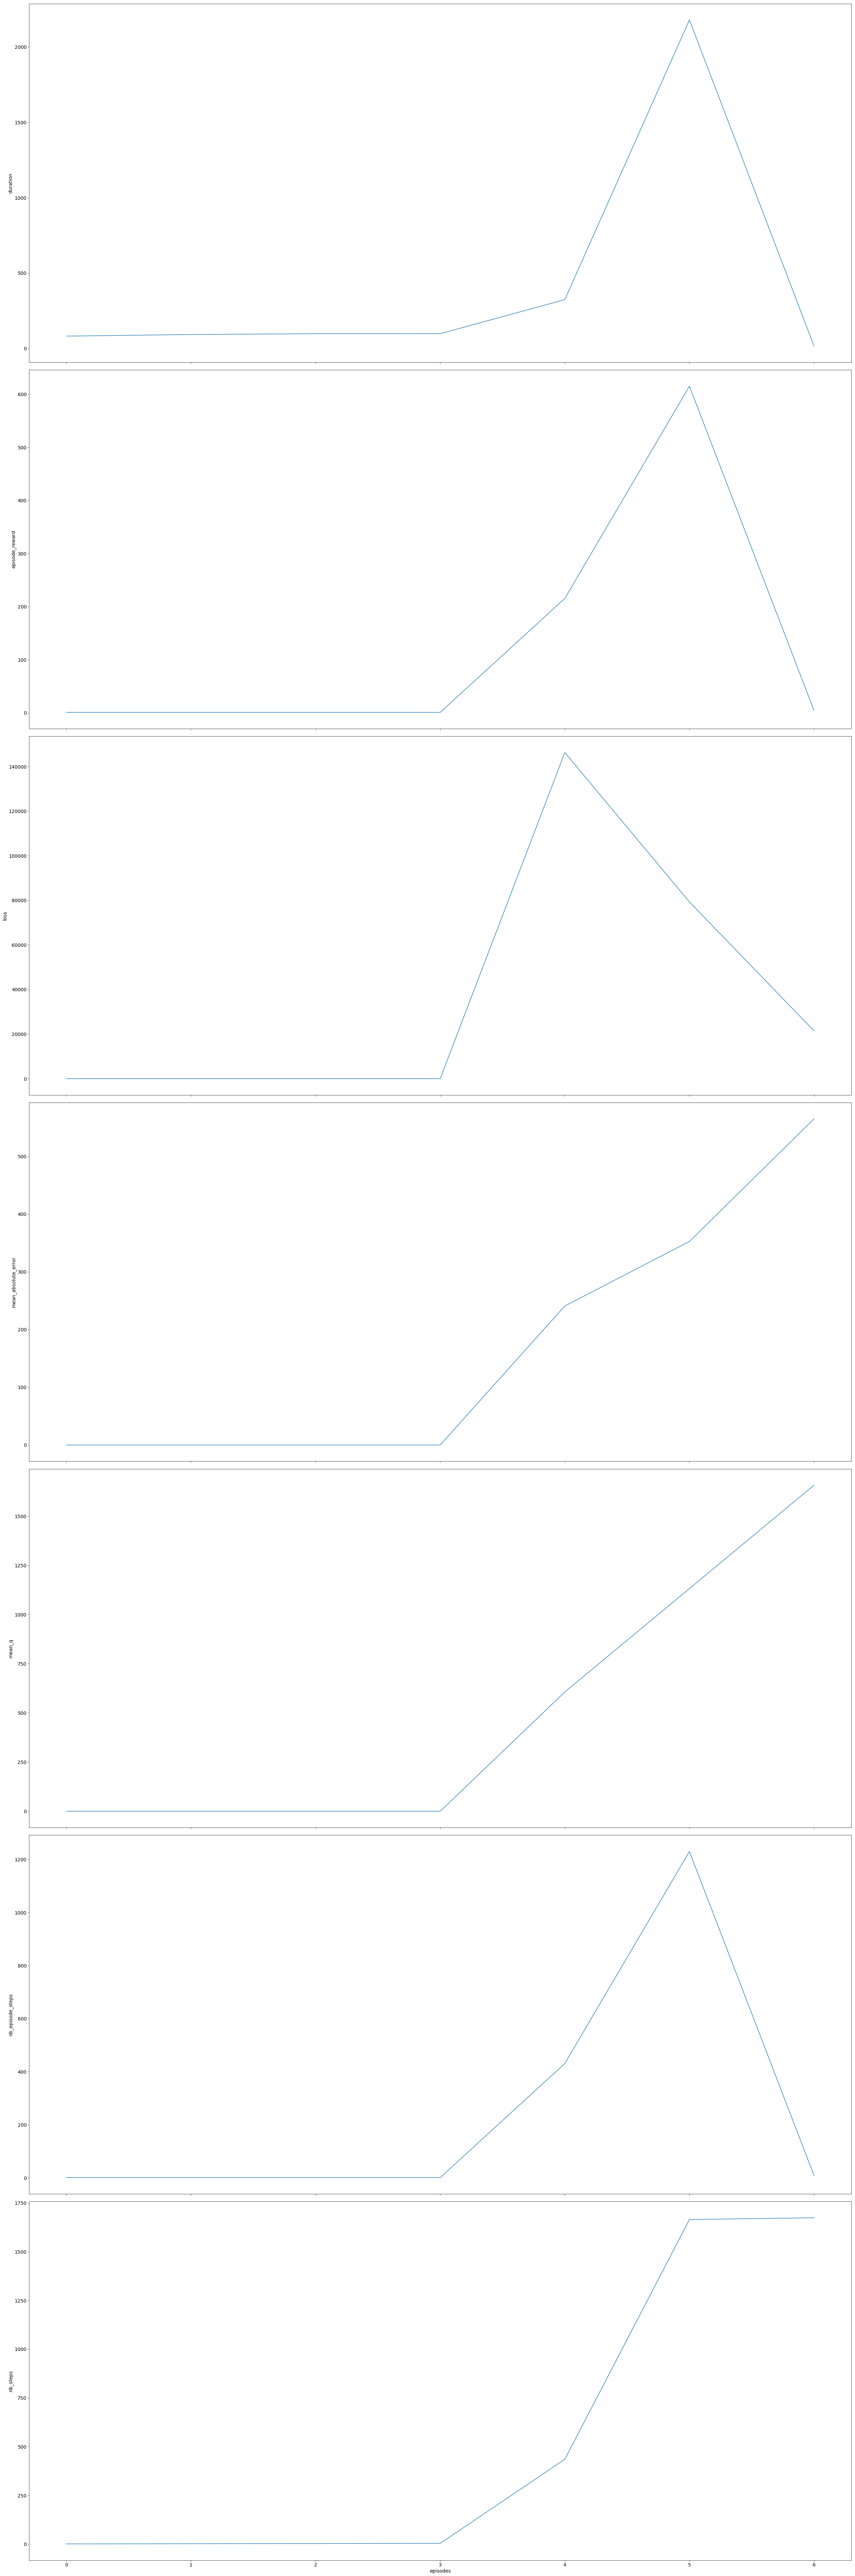

In [214]:
#visualize_log(args.filename, output=args.output, figsize=args.figsize)
visualize_log('mydqn_micro_with_swarmed_log.json')
#mydqn_micro_with_swarmed_log.json

In [148]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, expand_nested=True, rankdir='TB', to_file='model.png')